In [1]:
import cv2
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../PRNet")
from api import PRN
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '' # cpu
prn = PRN(is_dlib = True, prefix="../../PRNet")
from utils.render import render_texture
from utils.rotate_vertices import frontalize
from utils.estimate_pose import estimate_pose
import numpy as np
import dlib
sys.path.insert(0, "../../deepfeatinterp")
import alignface

import alignface

import time
def warp_face(img_in, img_ref):
    #img_in is HD image
    # img_ref is synthesis image
    # Calculate position map and get pose and rotation matrix
    pos1 = prn.process(img_in) 
    vertices1 = prn.get_vertices(pos1)
    cam_mat1, pose1, R1 = estimate_pose(vertices1)
    pos2 = prn.process(img_ref) 
    vertices2 = prn.get_vertices(pos2)
    cam_mat2, pose2, R2 = estimate_pose(vertices2)

    # Rotation 3D vertices
    warp_vertices = np.matmul(np.matmul(vertices2,R2), np.linalg.inv(R1)) 

    # Do translation
    center2_warp_pt = np.mean(warp_vertices, axis=0)
    center1_pt = np.mean(vertices1, axis=0)
    warp_vertices = warp_vertices - (center2_warp_pt - center1_pt)

    # Render new synthesis image after doing transformation
    # t1 = time.time()
    texture_ref = cv2.remap(img_ref/255.0, pos2[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
    # print("Texture from pos map: ", time.time()-t1)

    [h, w, c] = img_ref.shape
    # t1 = time.time()
    
    color = prn.get_colors_from_texture(texture_ref)
    # print("Get color of texture: ", time.time()-t1)
    
    color_mask = np.ones((warp_vertices.shape[0], 1))
    t1 = time.time()
    new_image = render_texture(warp_vertices.T, color.T, prn.triangles.T, h, w, c = 3)
    print("Time render: ", time.time()-t1)
    facemask = render_texture(warp_vertices.T, color_mask.T, prn.triangles.T, h, w, c = 3)

    # Using seamlessCloning to blending images
    vis_ind = np.argwhere(facemask>0)
    vis_min = np.min(vis_ind, 0)
    vis_max = np.max(vis_ind, 0)
    center = (int((vis_min[1] + vis_max[1])/2+0.5), int((vis_min[0] + vis_max[0])/2+0.5))
    output = cv2.seamlessClone((new_image*255).astype(np.uint8),(img_in).astype(np.uint8), (facemask*255).astype(np.uint8), center, cv2.NORMAL_CLONE)

    return output

model_path = "/home/vuthede/Downloads/shape_predictor_81_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model_path)
face_d,face_p=alignface.load_face_detector(predictor_path="/home/vuthede/AI/deepfeatinterp/models/shape_predictor_68_face_landmarks.dat")


def get_landmark(im1):
    det0 = detector(im1, 0)[0]
    shape = predictor(im1, det0)
    landmarks = np.matrix([[p.x, p.y] for p in shape.parts()])
    landmarks = np.array(landmarks)
    return landmarks

def draw_landmark(im, l, color =(0,255,0)):
    im_ = im.copy()
    for i in l:
        cv2.circle(im_, (i[0],i[1]), 3,color, -1)

    return im_

def warp_face_2D(img_in, img_ref):
    cv2.imwrite("tmp.png", img_ref)
    cv2.imwrite("tmp2.png", img_in)

    lm1 = get_landmark(img_ref)
    lm2 = get_landmark(img_in)
    # template,original=alignface.detect_landmarks("tmp.png",face_d,face_p)
    # template2,original2=alignface.detect_landmarks("tmp2.png",face_d,face_p)

    M,loss=alignface.fit_face_landmarks(lm1[:,::-1],lm2[:,::-1], landmarks=list(range(81)), scale_landmarks=[0,16],location_landmark=30,image_dims=img_in.shape[:2])

    warp_image = alignface.warp_to_template(img_ref,M,border_value=(0.5,0.5,0.5),image_dims=img_in.shape)

    # cv2.imshow("warp image raw:", warp_image)

     # Find convex hull
    hull1 = []
    hull2 = []

   

    # template = np.array(template[:,::-1]).astype(int)
    # template2 = np.array(template2[:,::-1]).astype(int)

    show = draw_landmark(img_ref, lm1)
    # cv2.imshow("Lmk:", show)

    # print(template)
    # print(template.shape)

    hullIndex = cv2.convexHull(lm1, returnPoints = False)          
    for i in range(0, len(hullIndex)):
        hull1.append(lm1[int(hullIndex[i])])
        hull2.append(lm2[int(hullIndex[i])])
    
    hull1 = np.array(hull1)
    hull2 = np.array(hull2)

    mouth_mask = np.zeros(img_ref.shape, img_ref.dtype)
    cv2.fillPoly(mouth_mask, [hull2], (255, 255, 255))
    # cv2.imshow("mask:", mouth_mask)

    r = cv2.boundingRect(np.float32(hull2))    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
    clone = cv2.seamlessClone(warp_image, img_in, mouth_mask, center, cv2.NORMAL_CLONE)

    return clone



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `layer.__call__` method instead.





INFO:tensorflow:Restoring parameters from ../../PRNet/Data/net-data/256_256_resfcn256_weight


# Test demo

In [3]:
cap_hd = cv2.VideoCapture("../cropobamafullhd10s.mp4")
cap_syn = cv2.VideoCapture("../resultobamafullhd10s.mp4")

i = 0
while True:
    i +=1

    if i%15:
        ret1, hd = cap_hd.read()
        ret2, syn = cap_syn.read()

        if not ret1 or not ret2:
            print("Quit")
            # out.release()
            break

        # warp, transform = warp_face_2D(hd, syn)
        warp  = warp_face_2D(hd, syn)


        concat = np.hstack([hd, syn, warp])
        # concat = np.hstack([hd, syn,transform, warp])


        cv2.imshow("hd", hd)
        cv2.imshow("syn", syn)
        cv2.imshow("warp", warp)
        # cv2.imshow("transform", transform)
        cv2.imshow("concat", concat)
        # out.write(concat)




        k = cv2.waitKey(0)
        if k==27:
            # out.release()
            break

# out.release()
cv2.destroyAllWindows()
    

In [6]:
import random
quality_ranges = [(15, 75)]
for qr in quality_ranges:
    quality = int(random.random() * (qr[1] - qr[0]) + qr[0])
    

57


In [6]:
cap_hd = cv2.VideoCapture("../cropobamafullhd10s.mp4")
cap_syn = cv2.VideoCapture("../resultobamafullhd10s.mp4")
out = cv2.VideoWriter('./data_playing_2d.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (256*4, 256))

i = 0
while True:
    i +=1

    if i%15:
        ret1, hd = cap_hd.read()
        ret2, syn = cap_syn.read()

        if not ret1 or not ret2:
            print("Quit")
            out.release()
            break

        warp, transform = warp_face_2D(hd, syn)

        concat = np.hstack([hd, syn,transform, warp])

        cv2.imshow("hd", hd)
        cv2.imshow("syn", syn)
        cv2.imshow("warp", warp)
        cv2.imshow("transform", transform)
        cv2.imshow("concat", concat)
        out.write(concat)




        k = cv2.waitKey(0)
        if k==27:
            out.release()
            break

out.release()
cv2.destroyAllWindows()
    

In [2]:
def prepare_data_for_face_res(highresvideo, lowressyn, data_output, prefix='batch1', downsample=2, warp2d=True, warp3d=False):
    """
    /highres = 512x512
    /lowres  = 256x256 -->128x128
    /dataoutput = /--highres
                  /--lowres_warp2d
                  /--lowres_warp3d
    """
    
    highres_out = "highres"
    lowres_warp2d_out = "lowres_warp2d"
    lowres_warp3d_out = "lowres_warp3d"

    cap_high = cv2.VideoCapture(highresvideo)
    cap_low = cv2.VideoCapture(lowressyn)
    
    if not os.path.isdir(data_output):
        os.makedirs(data_output + "/" + highres_out)
        os.makedirs(data_output + "/" + lowres_warp2d_out)
        os.makedirs(data_output + "/" + lowres_warp3d_out)

   

    i = 0
    while True:
        ret1, hr = cap_high.read()
        ret2, lr = cap_low.read()

        if i%downsample==0:
            cv2.imwrite(f'{data_output}/{highres_out}/{prefix}_{i}.png', hr)


            assert hr.shape[:2]==(512,512) and lr.shape[:2]==(256,256) 
            hr_tmp = cv2.resize(hr, (256, 256))

            if warp2d:
                lr_warp2d = warp_face_2D(hr_tmp, lr)
                lr_warp2d = cv2.resize(lr_warp2d, (128, 128))

                cv2.imwrite(f'{data_output}/{lowres_warp2d_out}/{prefix}_{i}.png', lr_warp2d)
            if warp3d:
                lr_warp3d = warp_face(hr_tmp, lr)
                lr_warp3d = cv2.resize(lr_warp3d, (128, 128))
                cv2.imwrite(f'{data_output}/{lowres_warp3d_out}/{prefix}_{i}.png', lr_warp3d)

        i += 1


prepare_data_for_face_res(highresvideo="batches_highres/1.mp4", lowressyn="synthesis_guided_by_512x512/1.mp4",
                          data_output="train_data", prefix='batch1',
                          downsample=2, warp2d=True, warp3d=False)





error: OpenCV(4.2.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:715: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


# Test data

In [5]:
import glob
import cv2

highres = glob.glob("./train_data/highres/*.png")
for h in highres:
    l = h.replace("highres", "lowres_warp2d")
    h_im = cv2.imread(h)
    cv2.imshow("High", h_im)
    l_im = cv2.imread(l)
    l_im = cv2.resize(l_im, (512,512))
    cv2.imshow("Low",l_im)

    k = cv2.waitKey(0)

    if k ==27:
        break

cv2.destroyAllWindows()

In [3]:
import numpy as np
import glob

def get_loss_lmks(data_path):
    highres = glob.glob(data_path + "/highres/*.png")
    losses = {}
    for h in highres:
        l = h.replace("highres", "lowres_warp2d")
        h_im = cv2.imread(h)
        l_im = cv2.imread(l)
        l_im = cv2.resize(l_im, (512,512))

        h_lmk = get_landmark(h_im)
        l_lmk = get_landmark(l_im)
        losses[f'{os.path.basename(h)}'] = np.linalg.norm(h_lmk-l_lmk)
    
    return losses


losses = get_loss_lmks("./train_data")




(array([ 10.,  29., 119., 144., 158., 341., 209., 206., 220.,  99.,  63.,
         56.,  21.,  21.,  10.,   9.,   7.,   7.,   7.,   7.,   3.,   6.,
          3.,   3.,   2.,   8.,   3.,   0.,   1.,   0.,   2.,   0.,   5.,
          0.,   1.,   2.,   0.,   1.,   2.,   2.,   1.,   0.,   1.,   0.,
          1.,   0.,   0.,   2.,   2.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  9.  ,  11.34,  13.68,  16.02,  18.36,  20.7 ,  23.04,  25.38,
         27.72,  30.06,  32.4 ,  34.74,  37.08,  39.42,  41.76,  44.1 ,
         46.44,  48.78,  51.12,  53.46,  55.8 ,  58.14,  60.48,  62.82,
         65.16,  67.5 ,  69.84,  72.18,  74.52,  76.86,  79.2 ,  81.54,
         83.88,  86.22,  88.56

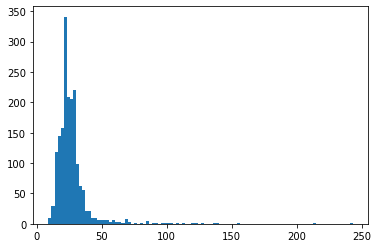

In [10]:
err = np.array(list(losses.values())).astype(int)
plt.hist(err, bins=100)

# Divide batches

In [5]:
import cv2
def concat_video_data(video, output_video):
    out = cv2.VideoWriter(f'./{output_video}',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (512, 512))    

    period = [[0,43*30], [5*60*30,9*60*30], [10*60*30, 13*60*30]]
    cap = cv2.VideoCapture(video)
    x1 = 685
    y1 = 85 
    x2 = 1250
    y2 = 650

    for p in period:
        cap.set(1, p[0])
        num_frames = p[1]-p[0]
        for i in range(num_frames):
            ret, img = cap.read()
            img = img[y1:y2, x1:x2]
            img = cv2.resize(img, (512,512))
            out.write(img)
        print("Finish one period")
    
    out.release()
    cv2.destroyAllWindows()

concat_video_data("../obama_fullhd.mp4", output_video="concat_obama_512x512.mp4")



Finish one period
Finish one period
Finish one period


In [7]:
cap = cv2.VideoCapture("concat_obama_512x512.mp4")
ret, img = cap.read()
ret

True

In [11]:
import os
import cv2

def cut_batch_data(video, output_dir, down_to_256=False):
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
        
    cap = cv2.VideoCapture(video)
    batch = 0
    i = 0
    while True:
        ret, img = cap.read()
        # print(img.shape)

        if not ret:
            out.release()
            break
            
        if i%(60*30*2)==0:
            batch +=1
            if down_to_256:
                out = cv2.VideoWriter(f'./{output_dir}/{batch}.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (256, 256))    
            else:
                out = cv2.VideoWriter(f'./{output_dir}/{batch}.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (512, 512))    

            print("New batch")

        out.write(img)
        i+=1

    out.release()


cut_batch_data("./concat_obama_512x512.mp4",output_dir="batches_highres")



New batch
New batch
New batch
New batch


In [12]:
cap = cv2.VideoCapture("./batches_highres/4.mp4")
ret, img = cap.read()
ret

True